In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
! rm -r /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data
! unzip -q /content/drive/Shareddrives/Giaquinta_Pasqualetti/Data.zip -d /

Once again, let's import the needed class and declare some global variables to be used if needed

In [ ]:
! rm -r /content/sample_data
! unzip -q /content/Data.zip -d /content/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras import layers
from keras import models
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import time
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from sklearn import metrics

ROOT_DIR = "/content/"

IMAGES_DIR = os.path.join(ROOT_DIR, "Data")
MODELS_DIR = os.path.join(ROOT_DIR, "Models")
TRAIN_DIR = os.path.join(IMAGES_DIR, "Train")
TEST_DIR = os.path.join(IMAGES_DIR, "Test")

IMAGE_DIM = 64
RAN_SEED = 10024062

VALIDATION_SPLIT = 0.1
TRAIN_SPLIT = 0.2

BATCH = 32
EPOCHS = 30

Unzip the previosly generated Dataset
  - It contains Train and Test folders, already evenly divided

In [ ]:
classes = os.listdir(TRAIN_DIR)

for c in classes:
    trainDir = os.path.join(TRAIN_DIR, c)
    testDir = os.path.join(TEST_DIR, c)

    print(f"{c}:\t\tTrain-{len(os.listdir(trainDir))}\tTest-{len(os.listdir(testDir))}")

Industrial:		Train-2000	Test-500
AnnualCrop:		Train-2400	Test-600
Highway:		Train-2000	Test-500
PermanentCrop:		Train-2000	Test-500
Residential:		Train-2400	Test-600
River:		Train-2000	Test-500
Pasture:		Train-2000	Test-400
SeaLake:		Train-2400	Test-600
Forest:		Train-2400	Test-600
HerbaceousVegetation:		Train-2400	Test-600


Let's decleare some Utilty functions:
 - **set_seed** is used to initialize all Random libraries. Doing so, we can create every set and model starting from the same point
 - **load_datasets** inizialize all seeds, then creates the 3 datasets: Train, Validation and Test
 - **show_res** gives a fast view of the performance of a given model results
 - **compile_fit** takes a model in input, compile it and fit with given data and epochs number
 - **train_performance** evaluates a model on the test set and prints graphs to analyze it


To also reduce the computation time, we added also an EarlyStopping and a Checkpoint, both for min val_loss

In [ ]:
# Set all the seeds, to create datasets and Tensors from the same starting point
def set_seed():
    os.environ["PYTHONHASHSEED"]="0"
    np.random.seed(RAN_SEED)
    rn.seed(RAN_SEED)
    tf.random.set_seed(RAN_SEED)

# Returns Train, Val and Test sets
# BATCH_SIZE is user-given input, VALIDATION_SPLIT is 0.1
def load_datasets(BATCH_SIZE):
    set_seed()

    train = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='training', follow_links=False,
        image_size=(64,64)
    )

    val = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=None,
        color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True, seed=RAN_SEED,
        validation_split=VALIDATION_SPLIT, subset='validation', follow_links=False,
        image_size=(64,64)
    )

    test = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR, labels='inferred', label_mode='categorical',
        class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, shuffle=True,
        seed=RAN_SEED, follow_links=False, image_size=(64,64)
    )

    return train, val, test

# Returns some details about trained model
def train_performance(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Test
def show_res(model, test):
    data, labels = [], []

    for data_batch, labels_batch in test:
        data.append(data_batch)
        labels.append(labels_batch)

    data = tf.concat(data, axis=0)
    labels = tf.concat(labels, axis=0)

    checkName = model.name + ".h5"
    modelPath = os.path.join(MODELS_DIR, checkName)

    model = models.load_model(modelPath)

    y_score = model.predict(data)

    y_pred = np.rint(y_score) # to have 0 or 1

    y_true = np.asarray(labels)

    y_pred = np.argmax(y_score, axis=1)
    y_test = np.argmax(y_true, axis=1)

    print("Classification report: ")

    print(metrics.classification_report(y_test,y_pred ,digits = 4))

    cm = metrics.confusion_matrix(y_test, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    y_true = label_binarize(np.argmax(labels, axis=1), classes=range(10))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves in a single plot
    plt.figure()
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Compile and train a model for user-given number of epochs
def compile_fit(model, train, eps, valid, es = True):
    cbs = []
    earlyStop = callbacks.EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

    if es:
      cbs.append(earlyStop)

    checkName = model.name + ".h5"
    modelPath = os.path.join(MODELS_DIR, checkName)

    checkpoint = callbacks.ModelCheckpoint(filepath = modelPath,
                                monitor = 'val_loss',
                                verbose = 1,
                                mode ='min',
                                save_best_only = True)
    cbs.append(checkpoint)
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    return model.fit(
            train,
            epochs=eps,
            validation_data=valid,
            callbacks=cbs)

def model_summary(model):
  model.summary()
  from keras.utils import plot_model
  name = model.name + ".png"
  plot_model(model, show_layer_names=False, show_layer_activations=True, show_shapes=True, to_file = name)

### Model 1
Let's begin with some simple network and compare them:
  - 3 Conv2d-MaxPooling2D layers (16,32,64)
  - No Dropout or Hidden Dense layers were added

In [ ]:
input = keras.Input(shape=(64,64,3))
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=16, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
output = layers.Dense(10, activation='softmax')(x)

model1 = keras.Model(inputs=input, outputs=output, name="Model1")
model_summary(model1)

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                        

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/30
619/619 [==============================] - ETA: 0s - loss: 1.3039 - accuracy: 0.5018
Epoch 1: val_loss improved from inf to 0.94965, saving model to /content/Models/Model1.h5
619/619 [==============================] - 11s 11ms/step - loss: 1.3039 - accuracy: 0.5018 - val_loss: 0.9497 - val_accuracy: 0.6477
Epoch 2/30
614/619 [============================>.] - ETA: 0s - loss: 0.8471 - accuracy: 0.6959
Epoch 2: val_loss improved from 0.94965 to 0.72844, saving model to /content/Models/Model1.h5
619/619 [==============================] - 8s 12ms/step - loss: 0.8458 - accuracy: 0.6964 - val_loss: 0.7284 - val_accuracy: 0.7332
Epoch 3/30
612/619 [============================>.] - ETA: 0s - loss: 0.7027 - accuracy: 0.7512
Epoch 3: val_loss improved from 0.72844 to 0.67969, saving model to /c

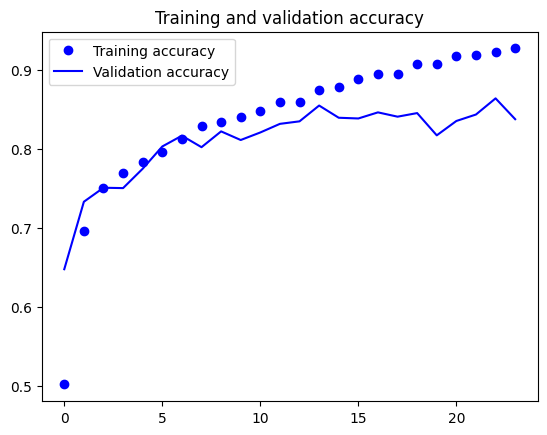

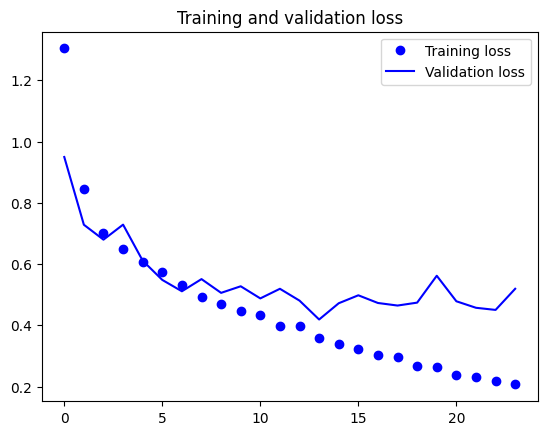

169/169 [==============================] - 0s 2ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9444    0.7650    0.8453       600
           1     0.9825    0.9367    0.9590       600
           2     0.7748    0.8083    0.7912       600
           3     0.7182    0.6320    0.6723       500
           4     0.9402    0.9120    0.9259       500
           5     0.7619    0.8800    0.8167       400
           6     0.6842    0.7280    0.7054       500
           7     0.9595    0.9483    0.9539       600
           8     0.7082    0.8640    0.7784       500
           9     0.9798    0.9700    0.9749       600

    accuracy                         0.8476      5400
   macro avg     0.8454    0.8444    0.8423      5400
weighted avg     0.8546    0.8476    0.8486      5400



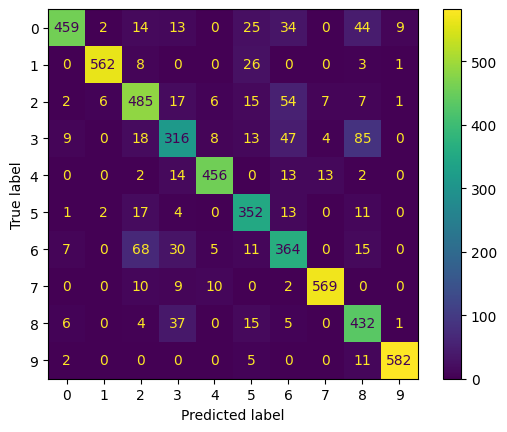

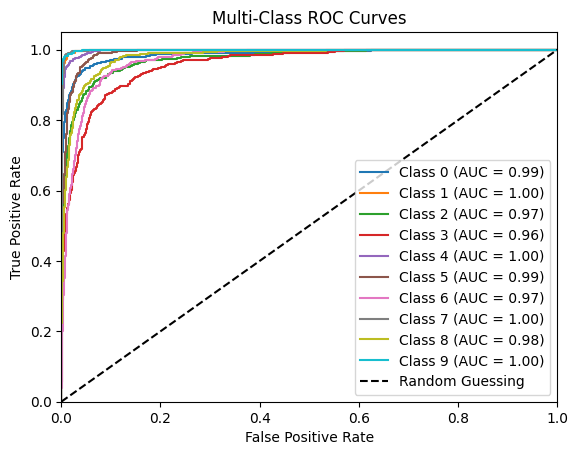

In [ ]:
train, val, test = load_datasets(BATCH)
res1 = compile_fit(model1, train, EPOCHS, val)
train_performance(res1)
show_res(model1, test)

As can be seen by the graphs, it presents overfitting

The precision is not that high (84%) and Classes 2, 3 and 6 along with 8 and 3 are giving most of the problems

###Model 2
The following model is the same as the previous, but the number of Conv2D Layers is doubled in each layer:
  - From (16,32,64) to (32,64,128)
  - Also added a Dropout layer in the end as a tentative to reduce overfitting

In [ ]:
input = keras.Input(shape=(64,64,3))
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(10, activation='softmax')(x)

model2 = keras.Model(inputs=input, outputs=output, name="Model2")
model_summary(model2)

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                        

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/30
619/619 [==============================] - ETA: 0s - loss: 1.3015 - accuracy: 0.5022
Epoch 1: val_loss improved from inf to 0.92243, saving model to /content/Models/Model2.h5
619/619 [==============================] - 10s 12ms/step - loss: 1.3015 - accuracy: 0.5022 - val_loss: 0.9224 - val_accuracy: 0.6745
Epoch 2/30
616/619 [============================>.] - ETA: 0s - loss: 0.8332 - accuracy: 0.6993
Epoch 2: val_loss improved from 0.92243 to 0.71762, saving model to /content/Models/Model2.h5
619/619 [==============================] - 8s 12ms/step - loss: 0.8324 - accuracy: 0.6995 - val_loss: 0.7176 - val_accuracy: 0.7445
Epoch 3/30
617/619 [============================>.] - ETA: 0s - loss: 0.7091 - accuracy: 0.7460
Epoch 3: val_loss did not improve from 0.71762
619/619 [==============

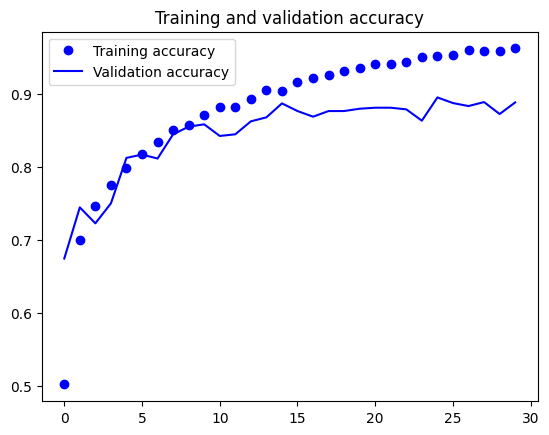

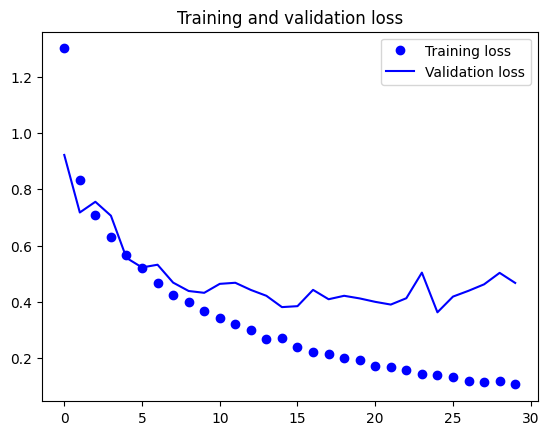

169/169 [==============================] - 0s 2ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8996    0.8517    0.8750       600
           1     0.9717    0.9733    0.9725       600
           2     0.7805    0.8417    0.8099       600
           3     0.8561    0.6900    0.7641       500
           4     0.9309    0.9160    0.9234       500
           5     0.8389    0.9375    0.8855       400
           6     0.7782    0.7720    0.7751       500
           7     0.9568    0.9600    0.9584       600
           8     0.7989    0.8740    0.8348       500
           9     0.9849    0.9800    0.9825       600

    accuracy                         0.8824      5400
   macro avg     0.8797    0.8796    0.8781      5400
weighted avg     0.8840    0.8824    0.8818      5400



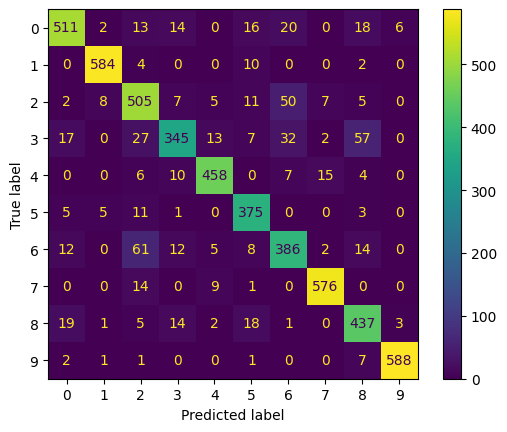

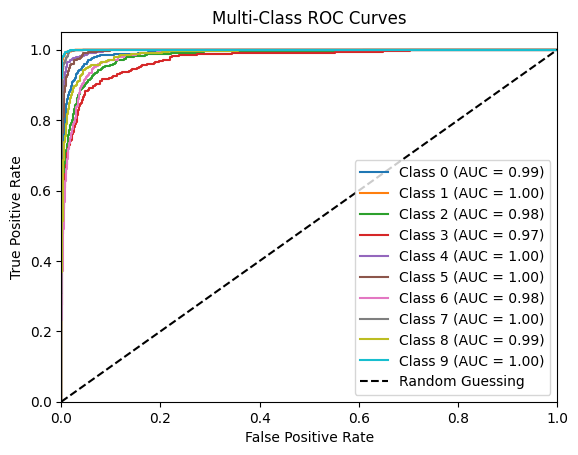

In [ ]:
train, val, test = load_datasets(BATCH)
res2 = compile_fit(model2, train, EPOCHS, val)
train_performance(res2)
show_res(model2, test)

Dropout decreased and overall accuracy is now about 88%, increased by a relative 4%

---



Let's try to add one Dense layer at the end and more dropout at each layer

### Model 3
Enhanchement of previous model:
  - Added more Dropout
  - Added a Dense layer with 64 neurons and L2-Regularization

In [ ]:
input = keras.Input(shape=(64,64,3))
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.1)(x)

output = layers.Dense(10, activation='softmax')(x)

model3 = keras.Model(inputs=input, outputs=output, name="Model3")
model_summary(model3)

Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                            

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/60
613/619 [============================>.] - ETA: 0s - loss: 1.6065 - accuracy: 0.4195
Epoch 1: val_loss improved from inf to 1.17808, saving model to /content/Models/Model3.h5
619/619 [==============================] - 10s 13ms/step - loss: 1.6031 - accuracy: 0.4208 - val_loss: 1.1781 - val_accuracy: 0.6068
Epoch 2/60
614/619 [============================>.] - ETA: 0s - loss: 1.1604 - accuracy: 0.6233
Epoch 2: val_loss improved from 1.17808 to 0.99993, saving model to /content/Models/Model3.h5
619/619 [==============================] - 7s 11ms/step - loss: 1.1597 - accuracy: 0.6234 - val_loss: 0.9999 - val_accuracy: 0.6823
Epoch 3/60
618/619 [============================>.] - ETA: 0s - loss: 1.0103 - accuracy: 0.6797
Epoch 3: val_loss improved from 0.99993 to 0.91839, saving model to /c

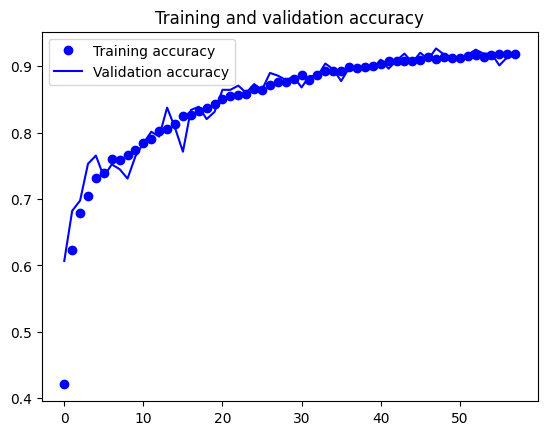

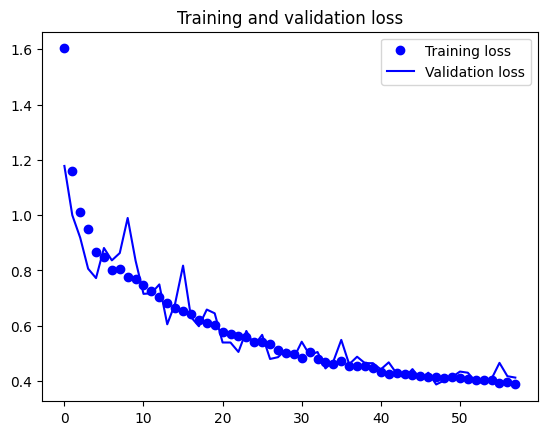

169/169 [==============================] - 1s 6ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9287    0.9117    0.9201       600
           1     0.9688    0.9817    0.9752       600
           2     0.9213    0.8200    0.8677       600
           3     0.9061    0.8680    0.8866       500
           4     0.9240    0.9720    0.9474       500
           5     0.8934    0.9425    0.9173       400
           6     0.8740    0.8740    0.8740       500
           7     0.9621    0.9733    0.9677       600
           8     0.8963    0.9160    0.9060       500
           9     0.9551    0.9933    0.9739       600

    accuracy                         0.9259      5400
   macro avg     0.9230    0.9253    0.9236      5400
weighted avg     0.9258    0.9259    0.9253      5400



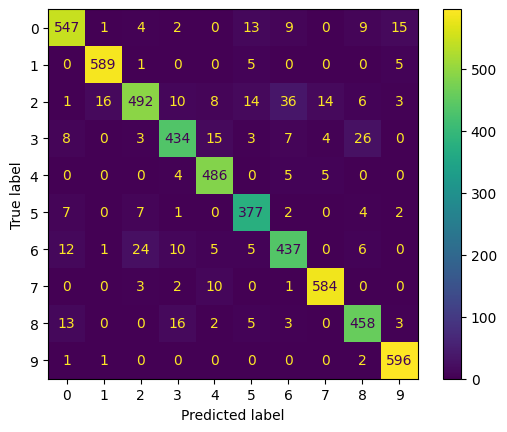

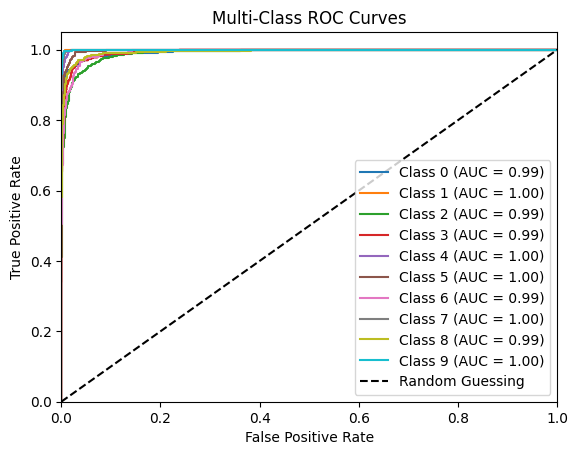

In [ ]:
train, val, test = load_datasets(BATCH)
res3 = compile_fit(model3, train, EPOCHS*2, val)
train_performance(res3)
show_res(model3, test)

The network now does not present any sign of overfitting and precision increased again by a relative 4%, reaching a value of 92%.

Let's add another Conv2D layer and another Dense layer in the end.

### Model 4
  - Added a forth Conv2D layer
  - Added another dense layer

In [ ]:
input = keras.Input(shape=(64,64,3))
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=256, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)

output = layers.Dense(10, activation='softmax')(x)

model4 = keras.Model(inputs=input, outputs=output, name="Model4")
model_summary(model4)

Model: "Model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                            

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/90
619/619 [==============================] - ETA: 0s - loss: 1.7169 - accuracy: 0.3544
Epoch 1: val_loss improved from inf to 1.23988, saving model to /content/Models/Model4.h5
619/619 [==============================] - 12s 14ms/step - loss: 1.7169 - accuracy: 0.3544 - val_loss: 1.2399 - val_accuracy: 0.5586
Epoch 2/90
619/619 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.5745
Epoch 2: val_loss improved from 1.23988 to 0.90192, saving model to /content/Models/Model4.h5
619/619 [==============================] - 8s 12ms/step - loss: 1.1954 - accuracy: 0.5745 - val_loss: 0.9019 - val_accuracy: 0.6995
Epoch 3/90
613/619 [============================>.] - ETA: 0s - loss: 1.0002 - accuracy: 0.6594
Epoch 3: val_loss improved from 0.90192 to 0.84829, saving model to /c

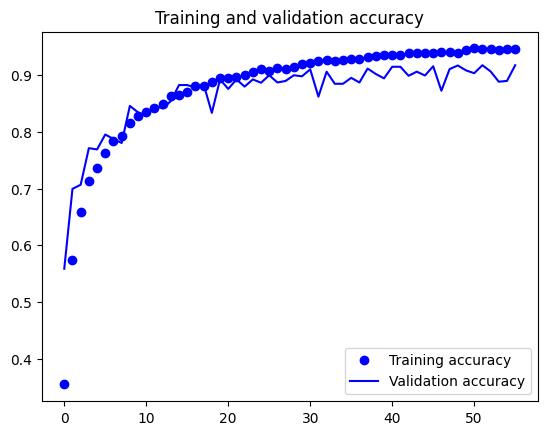

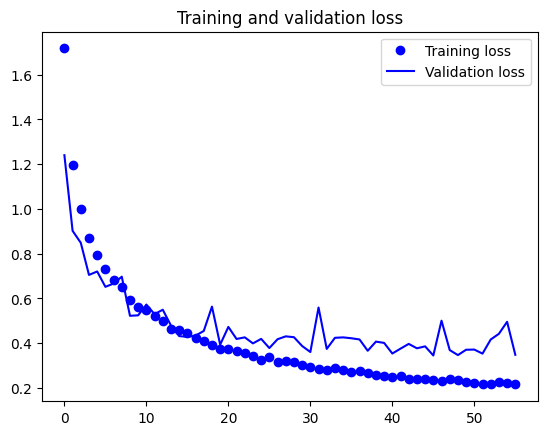

169/169 [==============================] - 1s 3ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9394    0.8533    0.8943       600
           1     0.9630    0.9533    0.9581       600
           2     0.8553    0.8867    0.8707       600
           3     0.9513    0.8600    0.9034       500
           4     0.9615    0.8980    0.9286       500
           5     0.8088    0.9625    0.8790       400
           6     0.8392    0.8140    0.8264       500
           7     0.9227    0.9950    0.9575       600
           8     0.9063    0.8900    0.8981       500
           9     0.9565    0.9900    0.9730       600

    accuracy                         0.9117      5400
   macro avg     0.9104    0.9103    0.9089      5400
weighted avg     0.9139    0.9117    0.9115      5400



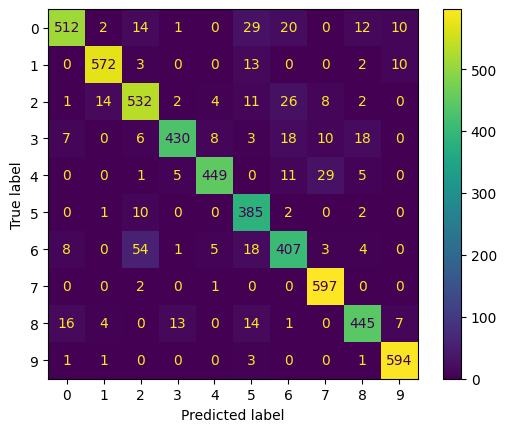

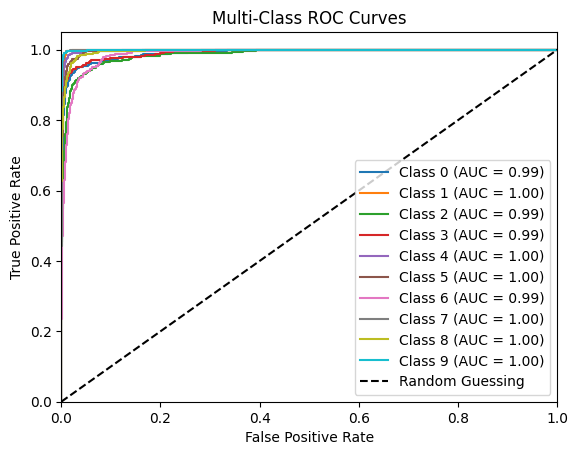

In [ ]:
train, val, test = load_datasets(BATCH)
res4 = compile_fit(model4, train, EPOCHS*3, val)
train_performance(res4)
show_res(model4, test)

Slightly less precision (91%), but higher overfitting on the long run caused by additional layers

We want to try another version with more dropout, and depending on results, we will try train for more epochs the best model until now

###Model 5
  - Conv2D layers were doubled while maintaining original filter quantity (32,64,128)
  - Increased Dropout on Dense layers

In [ ]:
input = keras.Input(shape=(64,64,3))
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.15)(x)

x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.15)(x)

x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.15)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)

output = layers.Dense(10, activation='softmax')(x)

model5 = keras.Model(inputs=input, outputs=output, name="Model5")
model_summary(model5)

Model: "Model5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 30, 30, 32)        0         
                                                            

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/120
615/619 [============================>.] - ETA: 0s - loss: 1.9655 - accuracy: 0.2449
Epoch 1: val_loss improved from inf to 1.53077, saving model to /content/Models/Model5.h5
619/619 [==============================] - 14s 17ms/step - loss: 1.9632 - accuracy: 0.2455 - val_loss: 1.5308 - val_accuracy: 0.4041
Epoch 2/120
617/619 [============================>.] - ETA: 0s - loss: 1.5307 - accuracy: 0.4133
Epoch 2: val_loss improved from 1.53077 to 1.26307, saving model to /content/Models/Model5.h5
619/619 [==============================] - 10s 16ms/step - loss: 1.5301 - accuracy: 0.4137 - val_loss: 1.2631 - val_accuracy: 0.6045
Epoch 3/120
616/619 [============================>.] - ETA: 0s - loss: 1.3056 - accuracy: 0.5443
Epoch 3: val_loss improved from 1.26307 to 0.98144, saving model t

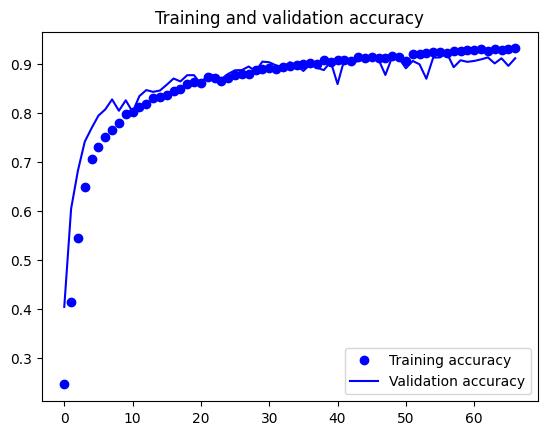

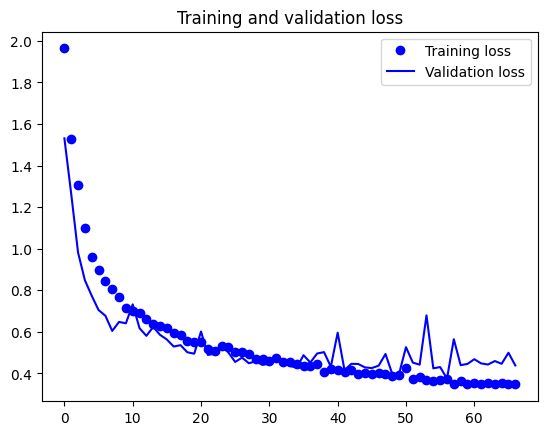

169/169 [==============================] - 1s 4ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9257    0.8717    0.8979       600
           1     0.9748    0.9683    0.9716       600
           2     0.8196    0.8783    0.8479       600
           3     0.9084    0.9120    0.9102       500
           4     0.9681    0.9100    0.9381       500
           5     0.8438    0.9450    0.8915       400
           6     0.8647    0.7800    0.8202       500
           7     0.9255    0.9933    0.9582       600
           8     0.9314    0.8960    0.9134       500
           9     0.9817    0.9817    0.9817       600

    accuracy                         0.9154      5400
   macro avg     0.9144    0.9136    0.9131      5400
weighted avg     0.9167    0.9154    0.9152      5400



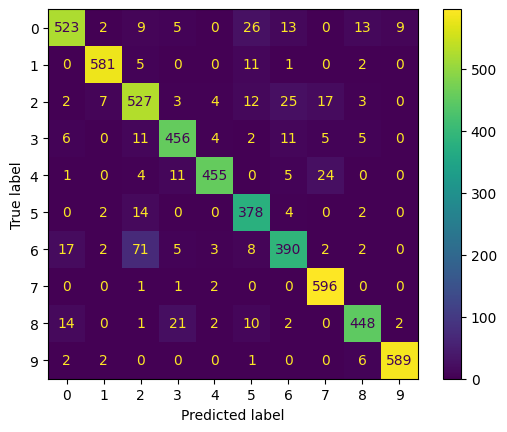

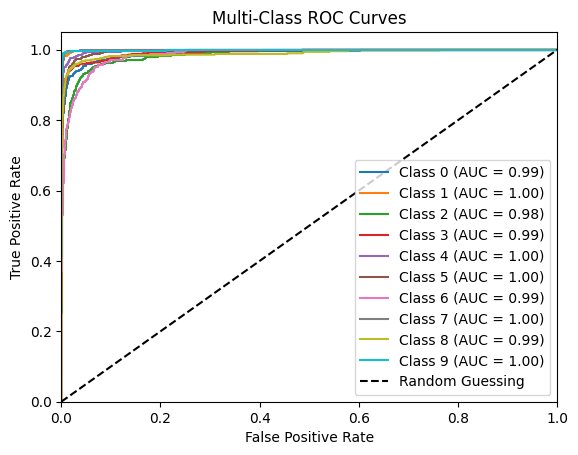

In [ ]:
train, val, test = load_datasets(BATCH)
res5 = compile_fit(model5, train, EPOCHS*4, val)
train_performance(res5)
show_res(model5, test)

Same accuracy results, but also a bit noisy validation accuracy and loss.

Adding more Dropout helped reducing overfitting on the long run.

Most of the misclassification is given by class 6 misinterpreteds as class 2.

###Model 6
  - Increased Conv2D Dropout
  - Doubled Dense layers filters
  - Increased Dense layers Dropout
  - Added l2-regularization on second hidden Dense layer too

In [ ]:
input = keras.Input(shape=(64,64,3))
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.Conv2D(filters=64, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size = 3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(10, activation='softmax')(x)

model6 = keras.Model(inputs=input, outputs=output, name="Model6")
model_summary(model6)

Model: "Model6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_47 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_48 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 30, 30, 32)        0         
                                                            

Found 22000 files belonging to 10 classes.
Using 19800 files for training.
Found 22000 files belonging to 10 classes.
Using 2200 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/100
618/619 [============================>.] - ETA: 0s - loss: 2.0902 - accuracy: 0.2571
Epoch 1: val_loss improved from inf to 1.59939, saving model to /content/Models/Model6.h5
619/619 [==============================] - 14s 17ms/step - loss: 2.0897 - accuracy: 0.2573 - val_loss: 1.5994 - val_accuracy: 0.4282
Epoch 2/100
619/619 [==============================] - ETA: 0s - loss: 1.5674 - accuracy: 0.3937
Epoch 2: val_loss improved from 1.59939 to 1.34150, saving model to /content/Models/Model6.h5
619/619 [==============================] - 10s 16ms/step - loss: 1.5674 - accuracy: 0.3937 - val_loss: 1.3415 - val_accuracy: 0.5050
Epoch 3/100
619/619 [==============================] - ETA: 0s - loss: 1.3672 - accuracy: 0.4999
Epoch 3: val_loss improved from 1.34150 to 1.10361, saving model t

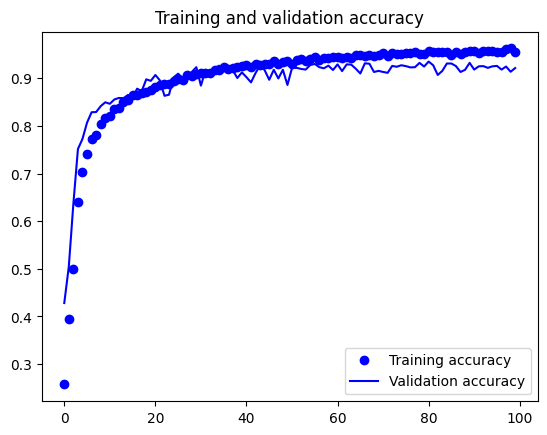

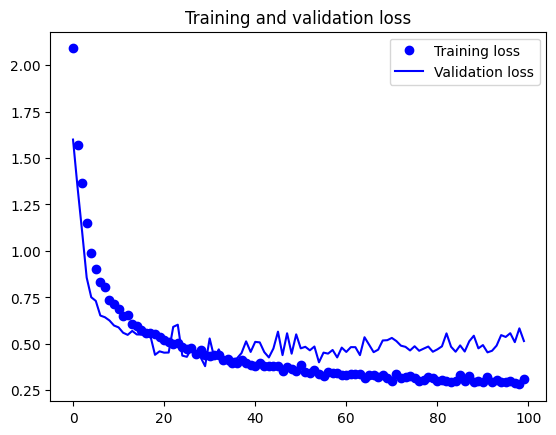

169/169 [==============================] - 1s 4ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9546    0.8417    0.8946       600
           1     0.9736    0.9850    0.9793       600
           2     0.8687    0.8383    0.8533       600
           3     0.8917    0.9220    0.9066       500
           4     0.9744    0.9140    0.9432       500
           5     0.8385    0.9475    0.8897       400
           6     0.7698    0.8560    0.8106       500
           7     0.9280    0.9883    0.9572       600
           8     0.9710    0.8700    0.9177       500
           9     0.9768    0.9833    0.9801       600

    accuracy                         0.9152      5400
   macro avg     0.9147    0.9146    0.9132      5400
weighted avg     0.9185    0.9152    0.9155      5400



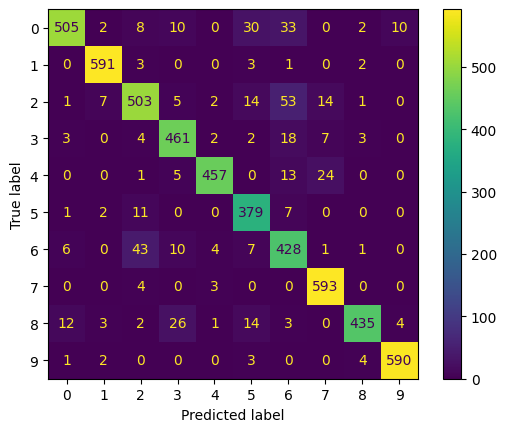

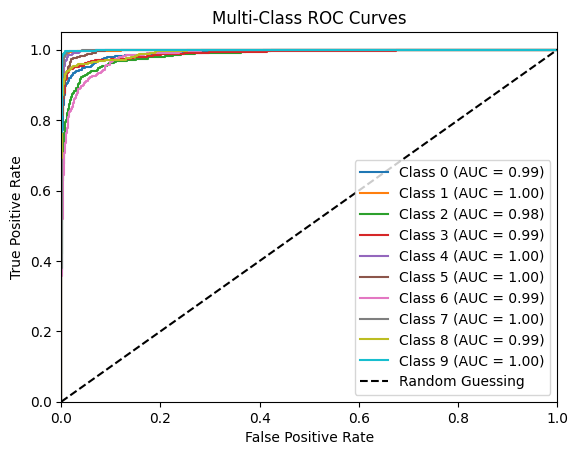

In [ ]:
train, val, test = load_datasets(BATCH)
res6 = compile_fit(model6, train, 100, val, es = False)
train_performance(res6)
show_res(model6, test)

Accuracy of last model is equals as same models, and increasing Dropout introduced somehow even more overfitting thn before.

Adding L2 Regularization on second Dense layer also, helped the model to reach higher accuracy sooner, but then overfitting starts to occurr.

---

In the end the best model is find out to be **Model3** whit an accuracy of 92%

  - Overall accuracy is decreased a lot by misclassification of classes 2, 3 and 6
  - We decided for Model 3 because it has the best tradeoff between accuracy, model simplicity and epochs needed to train.